In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datasets import Dataset, DatasetDict, load_dataset
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_context('notebook', font_scale=1.4)
plt.rcParams.update({
    'figure.figsize': (18, 8),
    'font.size': 32,
    'axes.titlesize': 28,
    'axes.labelsize': 25,
    'xtick.labelsize': 23,
    'ytick.labelsize': 23,
    'legend.fontsize': 21
})

## Ablation study of generated captions

We performed comparison between different LLM conditioning methods to show improvements in our methodology

In [5]:
base_dir = Path("../data/evaluation_results")
models = ['ft', 'base', 'zero_shot']
predictions = {}

for model in models:
    predictions[model] = {}
    pred_path = base_dir / f"{model}.csv"
    if pred_path.exists():
        predictions[model] = pd.read_csv(pred_path)

print(f"\nLoaded data for {len(models)} models")


Loaded data for 3 models


In [6]:
# Sample random id present in all models
common_ids = set.intersection(*(set(predictions[model]['id']) for model in models))
sample_id = np.random.choice(list(common_ids))
print(f"\nSample ID: {sample_id}\n")
for model in models:
    caption = predictions[model].loc[predictions[model]['id'] == sample_id, 'prediction'].values[0]
    aspects = predictions[model].loc[predictions[model]['id'] == sample_id, 'aspect_list'].values[0]
    print(f"{model}\n   aspects: {aspects}\n   caption: {caption}\n")


Sample ID: db92ce167960c791aa4c9429cc196a19

ft
   aspects: ['clapping', 'claps', 'drums', 'emotional', 'exciting', 'flat male vocal', 'groovy bass', 'hypnotic', 'passionate', 'passionate male vocal', 'punchy kick', 'r&b', 'soft']
   caption: This R&B track begins with hypnotic clapping rhythms accompanied by driving drums and punchy kick, building anticipation for the emotional vocals which feature a flat but passionate tone. A groovy bassline underscores the steady beat while soothingly soft passages give way to explosive moments showcasing bold harmonies and heartfelt lyrics, culminating in an exciting climax where every element converges in a deeply moving crescendo.

base
   aspects: ['clapping', 'claps', 'drums', 'emotional', 'exciting', 'flat male vocal', 'groovy bass', 'hypnotic', 'passionate', 'passionate male vocal', 'punchy kick', 'r&b', 'soft']
   caption: This R&B-infused track features a hypnotic groove anchored by a punchy kick drum and groovy bassline, creating an exci

### Create huggingface datasets for audio inference

In [29]:
for model in models:
    df = predictions[model]
    hf_dataset = Dataset.from_pandas(df)
    hf_dataset_dict = DatasetDict({ 'test': hf_dataset })
    hf_dataset_dict.push_to_hub(f"bsienkiewicz/{model}-caption-inference-dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


In [30]:
quick_test = pd.read_csv(base_dir / "quick_test.csv")
hf_dataset = Dataset.from_pandas(quick_test)
hf_dataset_dict = DatasetDict({ 'test': hf_dataset })
hf_dataset_dict.push_to_hub("bsienkiewicz/quick-test-caption-inference-dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/bsienkiewicz/quick-test-caption-inference-dataset/commit/cfc5ede9670d1660bd97f605626a1b475299439d', commit_message='Upload dataset', commit_description='', oid='cfc5ede9670d1660bd97f605626a1b475299439d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/bsienkiewicz/quick-test-caption-inference-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='bsienkiewicz/quick-test-caption-inference-dataset'), pr_revision=None, pr_num=None)

## Analyse ConceptCaps final captions

We used imprved prompt that further condensed generated caption to better match MusicCaps descriptions

In [7]:
final_dir = Path("../data/generated_captions/")
splits = ['train', 'validation', 'test']
captions = {}
datasets = {}

for split in splits:
    pred_path = final_dir / f"final_{split}.csv"
    df = pd.read_csv(pred_path)
    dataset = Dataset.from_pandas(df)
    captions[split] = df
    datasets[split] = dataset
    print(f"Loaded {split}: {len(df)} samples")

Loaded train: 21433 samples
Loaded validation: 1191 samples
Loaded test: 1191 samples


### Load MusicCaps for comparison

In [8]:
mc_dataset = load_dataset("google/MusicCaps", split="train")
mc_df = mc_dataset.to_pandas()
captions['mc'] = mc_df

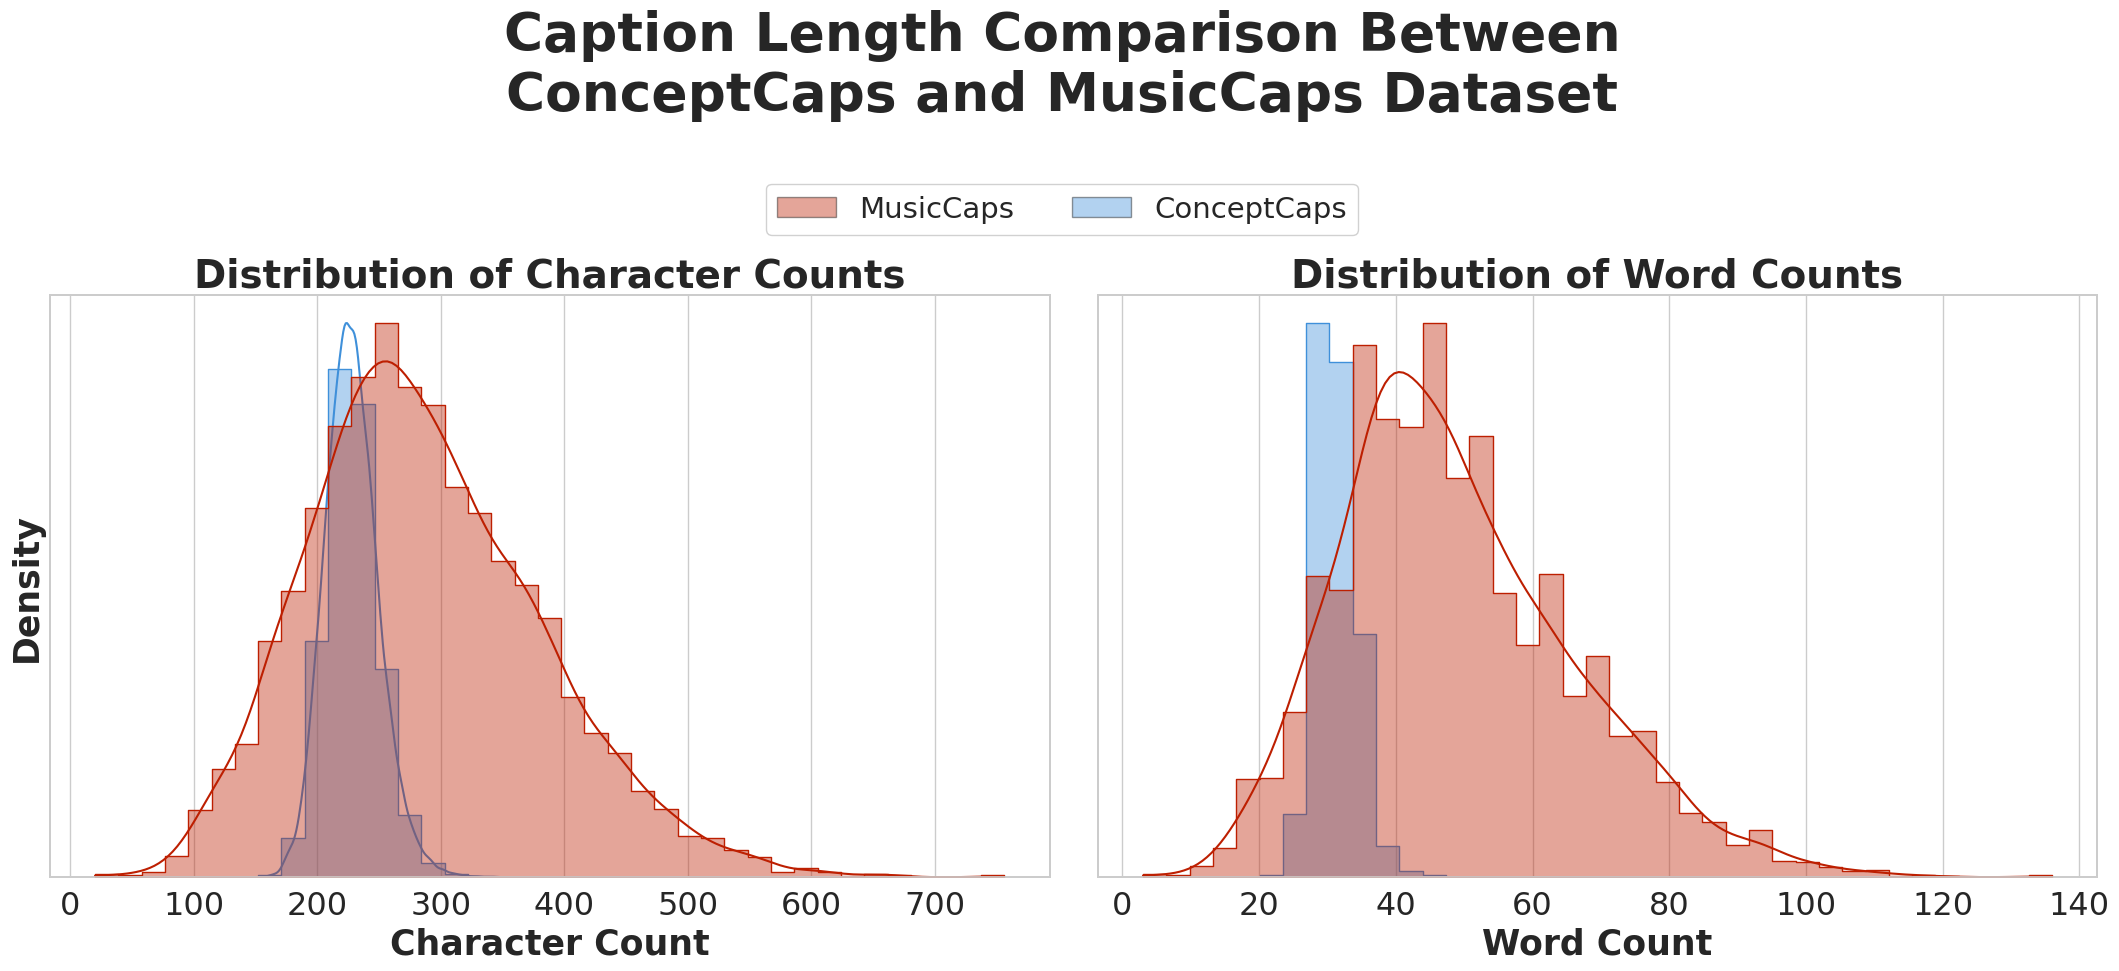

In [42]:
from matplotlib.patches import Patch
comparison_data = []
datasets = ['train', 'mc']
dataset_to_name = {
    'train': 'Fine-tuned Train',
    'mc': 'MusicCaps'
}

petroff_colors = ["#3f90da", "#bd1f01"]

for dataset in datasets:
    df = captions[dataset]
    col_name = 'prediction' if 'prediction' in df.columns else 'caption'
    df[col_name] = df[col_name].astype(str)
    
    word_counts = df[col_name].apply(lambda x: len(x.split()))
    char_counts = df[col_name].apply(len)
    
    # Create temporary dataframe for plotting
    temp_df = pd.DataFrame({
        'Dataset': dataset_to_name[dataset],
        'Word Count': word_counts,
        'Character Count': char_counts
    })
    comparison_data.append(temp_df)

viz_df = pd.concat(comparison_data, ignore_index=True)

# Split data
ft_df = viz_df[viz_df['Dataset'] != 'MusicCaps']
mc_df = viz_df[viz_df['Dataset'] == 'MusicCaps']

# Define consistent bins for both datasets
char_bins = np.linspace(viz_df['Character Count'].min(), viz_df['Character Count'].max(), 40)
word_bins = np.linspace(viz_df['Word Count'].min(), viz_df['Word Count'].max(), 40)

fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# Character counts with dual y-axis
ax0_twin = axes[0].twinx()
sns.histplot(
    data=ft_df, 
    x='Character Count', 
    kde=True, 
    element='step', 
    stat='density', 
    common_norm=False,
    alpha=0.4, 
    ax=axes[0],
    bins=char_bins,
    color=petroff_colors[0]
)
sns.histplot(
    data=mc_df, 
    x='Character Count', 
    kde=True, 
    element='step', 
    stat='density', 
    alpha=0.4,
    ax=ax0_twin,
    bins=char_bins,
    label='MusicCaps',
    color=petroff_colors[1]
)
axes[0].set_title('Distribution of Character Counts', fontweight='bold')
axes[0].set_xlabel('Character Count', fontweight='bold')
axes[0].set_ylabel('Density', fontweight='bold')
ax0_twin.set_ylabel('')

# Word counts with dual y-axis
ax1_twin = axes[1].twinx()
sns.histplot(
    data=ft_df, 
    x='Word Count', 
    kde=False, 
    element='step', 
    stat='density', 
    common_norm=False,
    alpha=0.4,
    ax=axes[1],
    bins=word_bins,
    color=petroff_colors[0]
)
sns.histplot(
    data=mc_df, 
    x='Word Count', 
    kde=True, 
    element='step', 
    stat='density', 
    alpha=0.4,
    ax=ax1_twin,
    bins=word_bins,
    label='MusicCaps',
    color=petroff_colors[1]
)
axes[1].set_title('Distribution of Word Counts', fontweight='bold')
axes[1].set_xlabel('Word Count', fontweight='bold')
axes[1].set_ylabel('')
ax1_twin.set_ylabel('')

# Disable y tick values
ax0_twin.set_yticks([])
axes[0].set_yticks([])
ax1_twin.set_yticks([])
axes[1].set_yticks([])

legend_elems = [Patch(facecolor=petroff_colors[1], edgecolor='black', label='MusicCaps', alpha=0.4),
                Patch(facecolor=petroff_colors[0], edgecolor='black', label='ConceptCaps', alpha=0.4)]
fig.legend(handles=legend_elems, loc='upper center', ncol=2, framealpha=0.9, bbox_to_anchor=(0.5, 1.05))
plt.tight_layout()
plt.suptitle('Caption Length Comparison Between\nConceptCaps and MusicCaps Dataset', fontweight='bold', y=1.25)
plt.style.use('petroff10')
plt.savefig("../docs/assets/caption_length_comparison.pdf", bbox_inches='tight')
plt.show()

In [28]:
for split, df in captions.items():
    if split == 'mc':
        continue
    print(f"{split} - Avg Prediction Length: {df['prediction'].astype(str).apply(len).mean()}")

train - Avg Prediction Length: 228.19232025381422
validation - Avg Prediction Length: 227.88832913518053
test - Avg Prediction Length: 228.8094038623006


In [29]:
for split, df in captions.items():
    if split == 'mc':
        continue
    df['word_count'] = df['prediction'].astype(str).apply(lambda x: len(x.split()))
    print(f"{split} - Avg Word Count: {df['word_count'].mean()}")

train - Avg Word Count: 31.143890262679047
validation - Avg Word Count: 31.144416456759025
test - Avg Word Count: 31.190596137699412


In [30]:
hf_dataset_dict = DatasetDict({ split: datasets[split] for split in splits })
hf_dataset_dict.push_to_hub("bsienkiewicz/final-caption-inference-dataset")

TypeError: list indices must be integers or slices, not str